### Solving Poisson Equation on S^2: $\Delta u = f$


In [1]:
import my_backends 
from my_backends.ducc0_wrapper import *
import my_shcoeffs
from my_shcoeffs import SHCoeffs
## my_shcoeffs contains expand_adjoint_analysis

[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\compare-notebooks\\PDPINN\\doc\\plmbar.doc'
[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\compare-notebooks\\PDPINN\\doc\\plmbar_d1.doc'
[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\compare-notebooks\\PDPINN\\doc\\plbar.doc'
[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\compare-notebooks\\PDPINN\\doc\\plbar_d1.doc'
[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\compare-notebooks\\PDPINN\\doc\\plmon.doc'
[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\compare-notebooks\\PDPINN\\doc\\plmon_d1.doc'
[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\compare-notebooks\\PDPINN\\doc\\plon.doc'
[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\compare-notebooks\\PDPINN\\doc\\plon_d1.doc'
[Errno 2] No such file or directory: 'C:\\Users\\ifisa\\Documents\\compare-notebooks\\PDPINN\\doc\\plmschmid

In [2]:
import torch

N = 20
from Basis import SPHBasis
from Problem import Problem_Sphere_Poisson
from Model import Model
from Net import Sphere_Net, SPH_Sphere_Net
import seaborn as sns
import matplotlib.pyplot as plt
import math
from math import pi
from spherical_harmonics import *
from torch.distributions.uniform import Uniform
from numpy import arccos
import numpy as np

import pyshtools
from pyshtools.shio import shread
from pyshtools.expand import MakeGridDH
from pyshtools.expand import SHExpandDH
from pyshtools.spectralanalysis import spectrum

torch.manual_seed(0)
maxiter = 6000
problem = Problem_Sphere_Poisson()

In [3]:
N = 20
azimuth = torch.linspace(0.0001, pi, N, requires_grad=False)
polar = torch.linspace(0, 2*pi, 2*N, requires_grad=False)

azimuth, polar = torch.meshgrid(azimuth, polar)
location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
location.shape

torch.Size([800, 2])

iteration 0: loss = 1223.813720703125, pde loss = 1223.76513671875


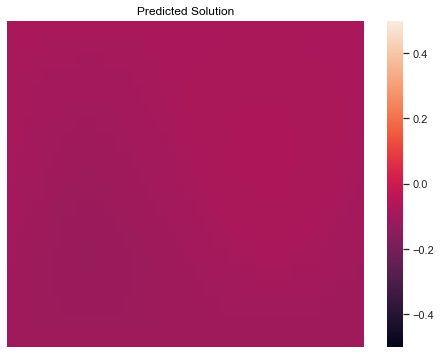

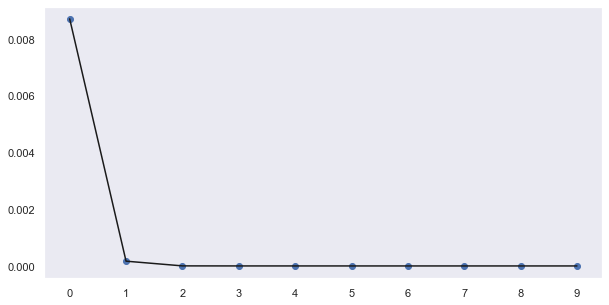

iteration 60: loss = 564.7874145507812, pde loss = 564.572265625
iteration 120: loss = 250.1068572998047, pde loss = 245.1463623046875
iteration 180: loss = 238.272216796875, pde loss = 234.35589599609375
iteration 240: loss = 234.9727783203125, pde loss = 231.4467315673828
iteration 300: loss = 227.38201904296875, pde loss = 224.24436950683594
iteration 360: loss = 199.25074768066406, pde loss = 196.52490234375
iteration 420: loss = 175.5197296142578, pde loss = 173.35333251953125
iteration 480: loss = 184.890380859375, pde loss = 182.35401916503906
iteration 540: loss = 174.49485778808594, pde loss = 172.41261291503906
iteration 600: loss = 173.8459930419922, pde loss = 172.09780883789062
iteration 660: loss = 173.40626525878906, pde loss = 171.94891357421875
iteration 720: loss = 173.0519256591797, pde loss = 171.8428497314453
iteration 780: loss = 172.75856018066406, pde loss = 171.7586669921875
iteration 840: loss = 172.5145263671875, pde loss = 171.68939208984375
iteration 900: l

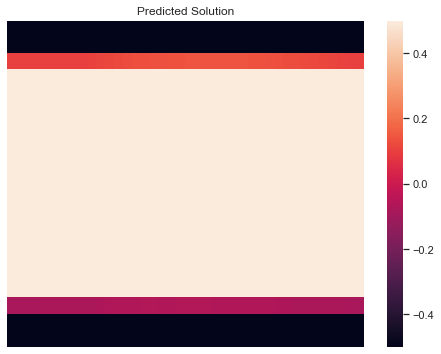

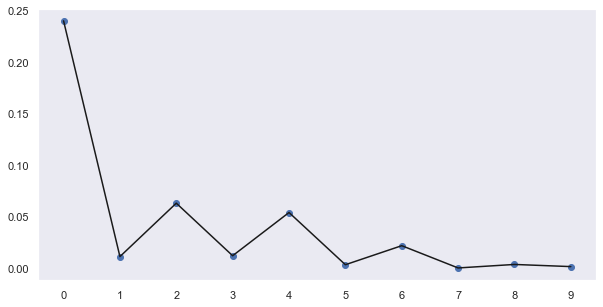

iteration 1260: loss = 171.68478393554688, pde loss = 171.4672393798828
iteration 1320: loss = 171.79949951171875, pde loss = 171.61886596679688
iteration 1380: loss = 171.57643127441406, pde loss = 171.42578125
iteration 1440: loss = 172.01336669921875, pde loss = 171.88937377929688
iteration 1500: loss = 171.66958618164062, pde loss = 171.56640625
iteration 1560: loss = 171.84498596191406, pde loss = 171.76132202148438
iteration 1620: loss = 170.9788818359375, pde loss = 170.9079132080078
iteration 1680: loss = 158.49609375, pde loss = 158.4749755859375
iteration 1740: loss = 137.62484741210938, pde loss = 137.62034606933594
iteration 1800: loss = 137.9271240234375, pde loss = 137.7522430419922
iteration 1860: loss = 134.35826110839844, pde loss = 134.27593994140625
iteration 1920: loss = 118.91256713867188, pde loss = 118.88197326660156
iteration 1980: loss = 114.65296936035156, pde loss = 114.64791107177734
iteration 2040: loss = 105.7786636352539, pde loss = 105.7785873413086
iter

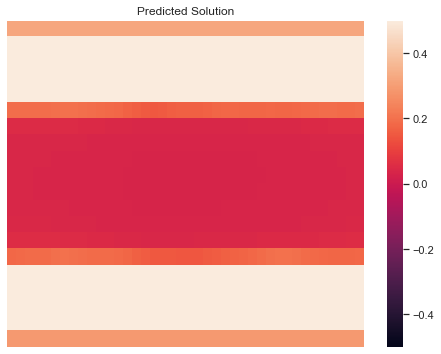

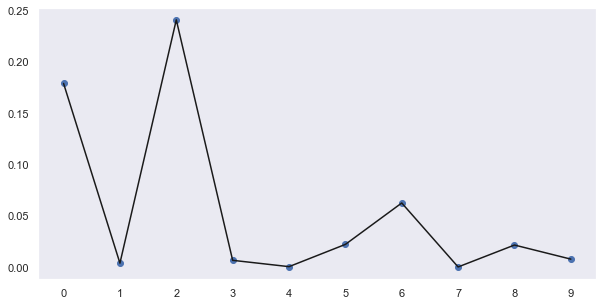

iteration 2460: loss = 98.02738189697266, pde loss = 98.02462768554688
iteration 2520: loss = 98.56830596923828, pde loss = 98.56615447998047
iteration 2580: loss = 97.90473175048828, pde loss = 97.90328979492188
iteration 2640: loss = 97.8434829711914, pde loss = 97.84224700927734
iteration 2700: loss = 97.79641723632812, pde loss = 97.79536437988281
iteration 2760: loss = 99.25093078613281, pde loss = 99.25015258789062
iteration 2820: loss = 97.71534729003906, pde loss = 97.71480560302734
iteration 2880: loss = 97.6772232055664, pde loss = 97.67671203613281
iteration 2940: loss = 97.6413803100586, pde loss = 97.64089965820312
iteration 3000: loss = 101.01780700683594, pde loss = 101.01744079589844
iteration 3060: loss = 97.58563995361328, pde loss = 97.58540344238281
iteration 3120: loss = 97.54609680175781, pde loss = 97.54583740234375
iteration 3180: loss = 97.5141830444336, pde loss = 97.51390838623047
iteration 3240: loss = 99.7648696899414, pde loss = 99.7645492553711
iteration 

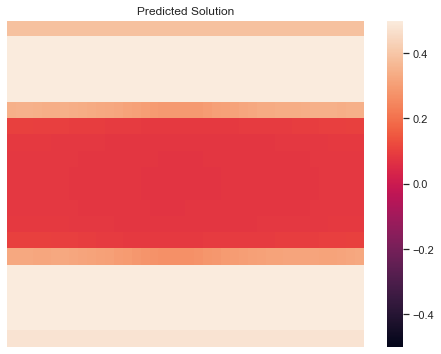

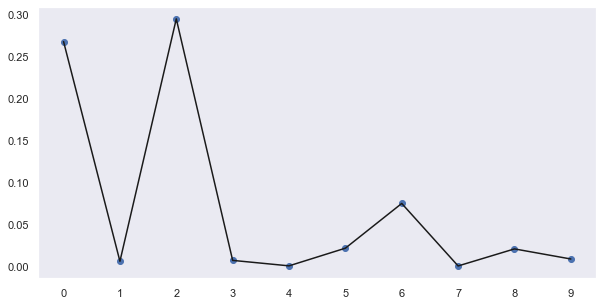

iteration 3660: loss = 97.8919906616211, pde loss = 97.89183807373047
iteration 3720: loss = 97.27972412109375, pde loss = 97.27958679199219
iteration 3780: loss = 97.23477935791016, pde loss = 97.234619140625
iteration 3840: loss = 97.19978332519531, pde loss = 97.19961547851562
iteration 3900: loss = 97.79238891601562, pde loss = 97.79228210449219
iteration 3960: loss = 97.15125274658203, pde loss = 97.15109252929688
iteration 4020: loss = 97.11038208007812, pde loss = 97.11021423339844
iteration 4080: loss = 97.22797393798828, pde loss = 97.22785186767578
iteration 4140: loss = 97.05577087402344, pde loss = 97.05563354492188
iteration 4200: loss = 97.07698822021484, pde loss = 97.07685852050781
iteration 4260: loss = 97.0020523071289, pde loss = 97.001953125
iteration 4320: loss = 96.94461822509766, pde loss = 96.94451141357422
iteration 4380: loss = 97.02054595947266, pde loss = 97.02046966552734
iteration 4440: loss = 96.86750793457031, pde loss = 96.867431640625
iteration 4500: l

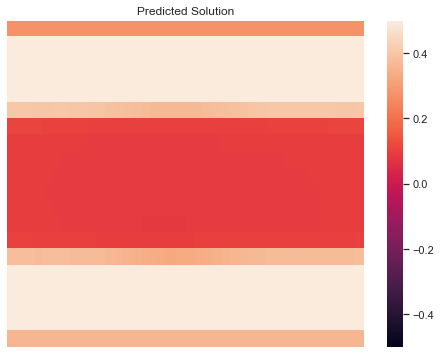

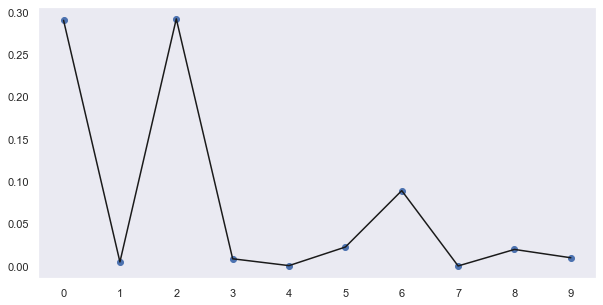

iteration 4860: loss = 99.91123962402344, pde loss = 99.91120147705078
iteration 4920: loss = 96.08541107177734, pde loss = 96.08541107177734
iteration 4980: loss = 96.81808471679688, pde loss = 96.81808471679688
iteration 5040: loss = 93.63616180419922, pde loss = 93.63555908203125
iteration 5100: loss = 65.6910400390625, pde loss = 65.64285278320312
iteration 5160: loss = 46.11458969116211, pde loss = 46.11320495605469
iteration 5220: loss = 44.43045425415039, pde loss = 44.425437927246094
iteration 5280: loss = 38.41213607788086, pde loss = 38.40950393676758
iteration 5340: loss = 42.58279800415039, pde loss = 42.582462310791016
iteration 5400: loss = 33.89767074584961, pde loss = 33.897666931152344
iteration 5460: loss = 30.6543025970459, pde loss = 30.654218673706055
iteration 5520: loss = 29.14940071105957, pde loss = 29.14887237548828
iteration 5580: loss = 14.392006874084473, pde loss = 14.392006874084473
iteration 5640: loss = 4.973730564117432, pde loss = 4.970044136047363
it

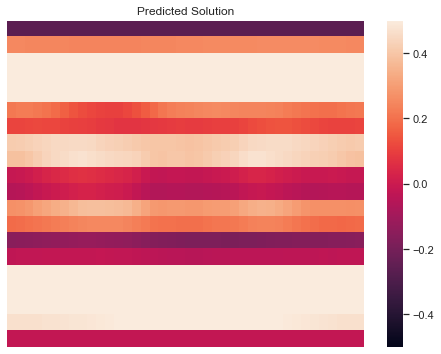

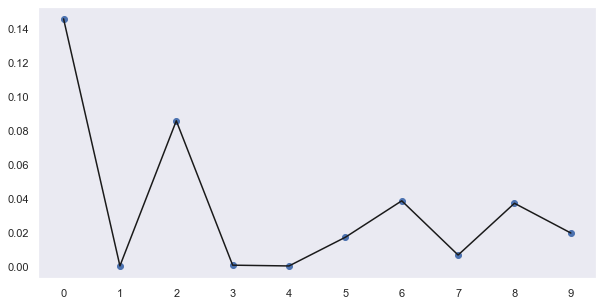

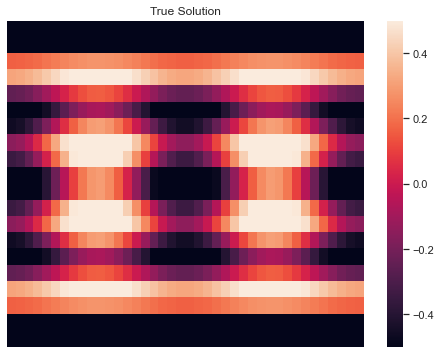

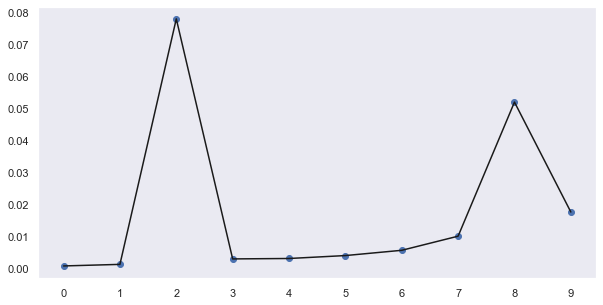

In [4]:

def construct_model(net):
    class Poisson1dModel(Model):
        def add_loss_history(self):
#             self.loss_history.append([self.bc_loss, self.pde_loss, self.predict_error_value])
            self.loss_history.append([self.pde_loss, self.predict_error_value])

        def __init__(self):
            super().__init__(problem=problem, net=net, maxiter=maxiter)

        def inner_sample(self, N=N):
            azimuth = torch.linspace(0.0001, pi, N, requires_grad=False)
            polar = torch.linspace(0, 2*pi, 2*N, requires_grad=False)
            
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            return location # numpy ndarray with shape (N, 2*N)

        def bc_sample(self):
            return torch.tensor([[1., 1.]]) # arbitrary point is okay?

        def init_sample(self):
            pass

        def plot(self, net):
            azimuth = torch.linspace(0, math.pi, N, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 2*N, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
#             location = self.inner_sample()
            value = net(location) # predicted solution
            
            value = value.reshape((N, 2*N))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Predicted Solution")
            plt.show()
            
            self.spherical_harmonic_transform(net)
        
        def spherical_harmonic_transform(self, net):
            azimuth = torch.linspace(0, math.pi, N, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 2*N, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            function_grid = net(location)
            function_grid = function_grid.reshape((N, 2*N))
            
            coefficients = SHExpandDH(function_grid.detach().numpy(), sampling=2)
            nl = coefficients.shape[1]
            ls = np.arange(nl)[:10]

            power_per_l = spectrum(coefficients)[:10]
            fig, ax = plt.subplots(1, 1, figsize=(len(ls), 5))
            ax.plot(ls, power_per_l, 'bo')
            ax.plot(ls, power_per_l, 'k-')
            plt.xticks(range(len(ls)))
            ax.grid()
            plt.show()
            
        
        def plot_true(self):
            azimuth = torch.linspace(0, math.pi, N, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 2*N, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            value = true_solution(location[:, 0:1], location[:, 1:])
            
            value = value.reshape((N, 2*N))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("True Solution")
            plt.show()
            
            self.sht_value(value)
            
        def sht_value(self, function_grid):
            function_grid = function_grid.reshape((N, 2*N))
            
            coefficients = SHExpandDH(function_grid.detach().numpy(), sampling=2)
            nl = coefficients.shape[1]
            ls = np.arange(nl)[:10]

            power_per_l = spectrum(coefficients)[:10]
            fig, ax = plt.subplots(1, 1, figsize=(len(ls), 5))
            ax.plot(ls, power_per_l, 'bo')
            ax.plot(ls, power_per_l, 'k-')
            plt.xticks(range(len(ls)))
            ax.grid()
            plt.show()
            
        def post_process(self, ax=None):
            if ax is None:
                for losses in self.loss_history:
                    for i in range(3):
                        losses[i].detach().numpy()
                plt.plot(self.loss_history)
                plt.yscale('log')
                plt.legend(('BC loss', 'pde loss', 'predict error'))
                plt.show()
            else:
                for losses in self.loss_history:
                    for i in range(3):
                        losses[i].detach().numpy()
                ax.plot(self.loss_history)
                ax.set_yscale('log')
                ax.set_ylim(1e-4, 100)
                ax.legend(('BC loss', 'pde loss', 'predict error'))

        def predict_error(self):
            coor = self.inner_sample()
            true = self.problem.ground_truth(coor)
            predict = self.net(coor)
            predict_error = self.pde_loss_f(true, predict)
            return predict_error

        def train(self, ax100=None):
            problem = self.problem
            net = self.net
            opt = self.opt
            maxiter = self.maxiter

            for iter in range(maxiter):
                net.zero_grad()

                coor_inner = self.inner_sample().detach().requires_grad_(True)
#                 coor_inner = self.inner_sample().requires_grad_(True)
                infer_value_inner = net(coor_inner)
#                 truth_inner, predict_inner = problem.pde(coor_inner, infer_value_inner)
                predict_inner, truth_inner = problem.pde(coor_inner, infer_value_inner) 
                ## order, is the lhs even the predicted value???
                ## reason the loss function is going up could be because we are computing the negative gradient, which could happen by switching the order of y, y_pred in orward and backward functions of the loss.
        
                self.pde_loss = self.pde_loss_f(predict_inner, truth_inner)
            
                bc_samples = self.bc_sample()
                if bc_samples is None:
                    self.bc_loss = torch.tensor(0.)
                else:
                    coor_bc = bc_samples.detach().requires_grad_(True)
                    infer_value_bc = net(coor_bc)
                    truth_bc, predict_bc = problem.bound_condition(coor_bc, infer_value_bc)
                    self.bc_loss = self.bc_loss_f(predict_bc, truth_bc)

                init_samples = self.init_sample()
                if init_samples is None:
                    self.init_loss = torch.tensor(0.)
                else:
                    coor_init = init_samples.detach().requires_grad_(True)
                    infer_value_init = net(coor_init)
                    truth_init, predict_init = problem.bound_condition(coor_init, infer_value_init)
                    self.init_loss = self.bc_loss_f(predict_init, truth_init)
                    
                self.predict_error_value = self.predict_error()
                self.total_loss = self.pde_loss + self.bc_loss + self.init_loss
                self.add_loss_history()
#                 self.total_loss.register_hook(lambda grad: print('gradient', grad))
                self.total_loss.backward()

                opt.step()
                opt.zero_grad()
#                 scheduler.step()
                
                if iter % (maxiter // 100) == 0:
                    print("iteration {}: loss = {}, pde loss = {}".format(iter, self.total_loss, self.pde_loss))
                        
                if iter % int(maxiter / 5) == 0:
                    self.plot(net)
                
            self.plot(net)
            self.plot_true()
#             self.post_process()

    return Poisson1dModel()

model = construct_model(Sphere_Net([3, 150, 50, 50, 50, 16, 1]))
model.train()


iteration 0: loss = 4.016824722290039, pde loss = 4.016824722290039


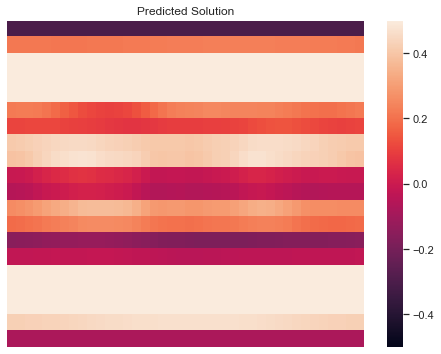

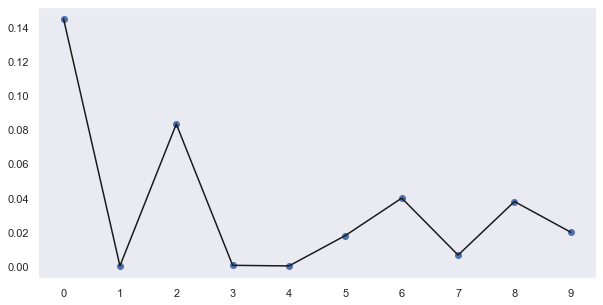

iteration 60: loss = 1.6581507921218872, pde loss = 1.657673954963684
iteration 120: loss = 1.3820884227752686, pde loss = 1.3818870782852173
iteration 180: loss = 1.4086123704910278, pde loss = 1.4085776805877686
iteration 240: loss = 1.2839215993881226, pde loss = 1.2838133573532104
iteration 300: loss = 1.1706016063690186, pde loss = 1.1704891920089722
iteration 360: loss = 1.2190700769424438, pde loss = 1.218894600868225
iteration 420: loss = 1.0577768087387085, pde loss = 1.057464838027954
iteration 480: loss = 1.0015102624893188, pde loss = 1.0012779235839844
iteration 540: loss = 0.9759394526481628, pde loss = 0.9752916097640991
iteration 600: loss = 0.8976877927780151, pde loss = 0.8973075747489929
iteration 660: loss = 0.9996100664138794, pde loss = 0.999056875705719
iteration 720: loss = 0.8057792782783508, pde loss = 0.8054776787757874
iteration 780: loss = 0.7860690951347351, pde loss = 0.7858570218086243
iteration 840: loss = 0.733250617980957, pde loss = 0.733072578907012

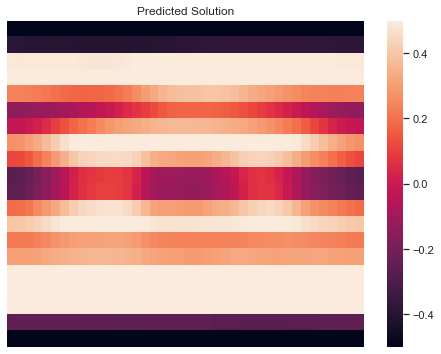

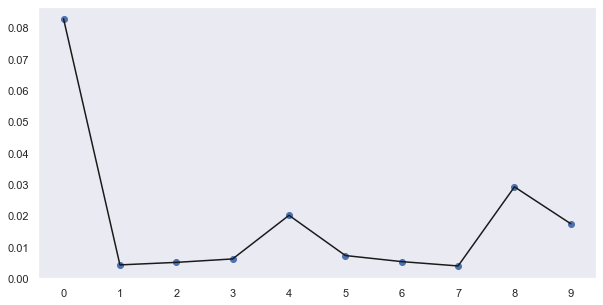

iteration 1260: loss = 0.773578941822052, pde loss = 0.7723729610443115
iteration 1320: loss = 0.6969985961914062, pde loss = 0.6963880062103271
iteration 1380: loss = 0.6324765682220459, pde loss = 0.6321410536766052
iteration 1440: loss = 0.5782517194747925, pde loss = 0.5780535936355591
iteration 1500: loss = 0.5316774249076843, pde loss = 0.5315577983856201
iteration 1560: loss = 0.49152281880378723, pde loss = 0.4914461076259613
iteration 1620: loss = 0.4566723704338074, pde loss = 0.45662185549736023
iteration 1680: loss = 0.42456361651420593, pde loss = 0.42452922463417053
iteration 1740: loss = 0.3953673839569092, pde loss = 0.39534252882003784
iteration 1800: loss = 0.3678395748138428, pde loss = 0.36781975626945496
iteration 1860: loss = 0.34148108959198, pde loss = 0.3414649963378906
iteration 1920: loss = 0.3162057399749756, pde loss = 0.3161907494068146
iteration 1980: loss = 0.29168257117271423, pde loss = 0.29166701436042786
iteration 2040: loss = 0.2679765820503235, pde

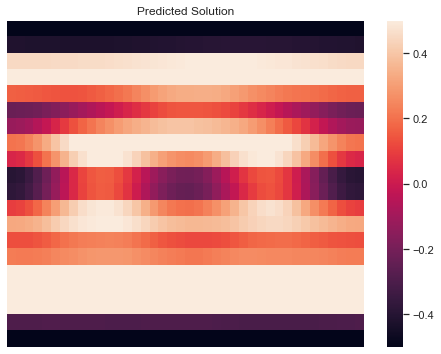

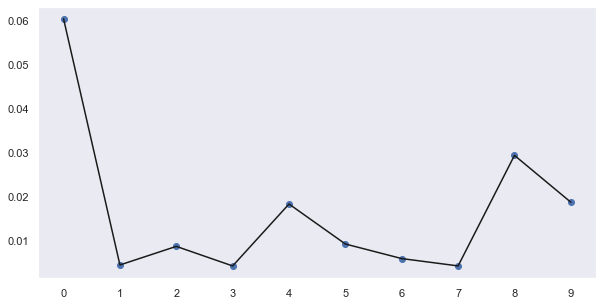

iteration 2460: loss = 0.13883867859840393, pde loss = 0.13881154358386993
iteration 2520: loss = 0.1263647824525833, pde loss = 0.12634047865867615
iteration 2580: loss = 0.11512113362550735, pde loss = 0.11509954184293747
iteration 2640: loss = 0.10513228923082352, pde loss = 0.10511354357004166
iteration 2700: loss = 0.09620351344347, pde loss = 0.09618683159351349
iteration 2760: loss = 0.08847416937351227, pde loss = 0.08846089988946915
iteration 2820: loss = 0.08136847615242004, pde loss = 0.08135678619146347
iteration 2880: loss = 0.07551725953817368, pde loss = 0.07550762593746185
iteration 2940: loss = 0.06960335373878479, pde loss = 0.06959513574838638
iteration 3000: loss = 0.0650605708360672, pde loss = 0.06505440920591354
iteration 3060: loss = 0.06023083254694939, pde loss = 0.06022540479898453
iteration 3120: loss = 0.056301943957805634, pde loss = 0.056297674775123596
iteration 3180: loss = 0.05272563919425011, pde loss = 0.05272187665104866
iteration 3240: loss = 0.049

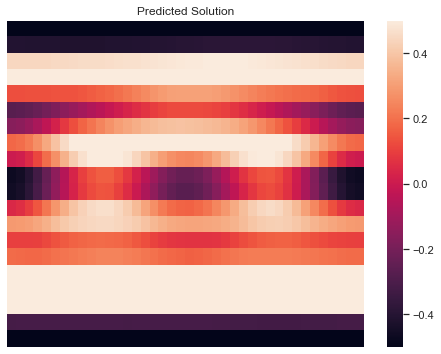

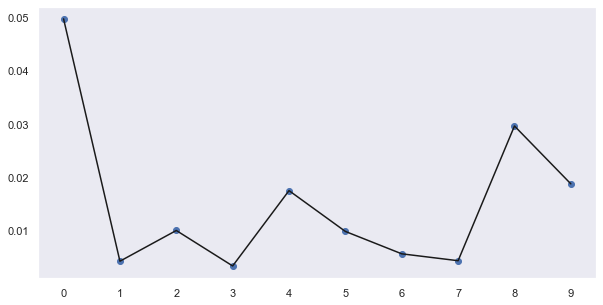

iteration 3660: loss = 0.03451458364725113, pde loss = 0.034513816237449646
iteration 3720: loss = 0.06983517855405807, pde loss = 0.06983348727226257
iteration 3780: loss = 0.03373050317168236, pde loss = 0.03372962400317192
iteration 3840: loss = 0.031392768025398254, pde loss = 0.031392645090818405
iteration 3900: loss = 0.02989513799548149, pde loss = 0.029895110055804253
iteration 3960: loss = 0.38819342851638794, pde loss = 0.3881917893886566
iteration 4020: loss = 0.03073003701865673, pde loss = 0.030725695192813873
iteration 4080: loss = 0.027357272803783417, pde loss = 0.027357272803783417
iteration 4140: loss = 0.0259060300886631, pde loss = 0.025906017050147057
iteration 4200: loss = 0.11080664396286011, pde loss = 0.11070339381694794
iteration 4260: loss = 0.03060213476419449, pde loss = 0.030592992901802063
iteration 4320: loss = 0.026850158348679543, pde loss = 0.026849661022424698
iteration 4380: loss = 0.024743523448705673, pde loss = 0.024743448942899704
iteration 4440

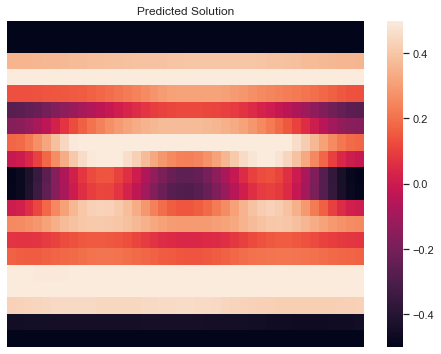

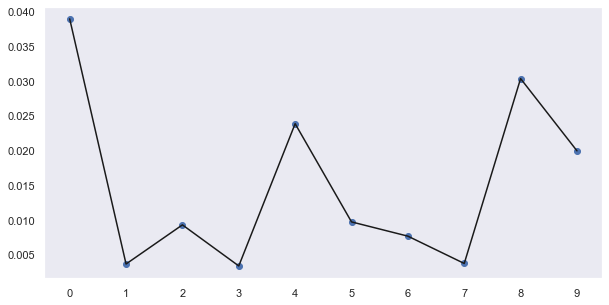

iteration 4860: loss = 0.02149007096886635, pde loss = 0.021489620208740234
iteration 4920: loss = 0.01848866418004036, pde loss = 0.01848861761391163
iteration 4980: loss = 0.4917590022087097, pde loss = 0.4917578101158142
iteration 5040: loss = 0.02361755073070526, pde loss = 0.023603832349181175
iteration 5100: loss = 0.020228588953614235, pde loss = 0.020228207111358643
iteration 5160: loss = 0.01744675450026989, pde loss = 0.017446650192141533
iteration 5220: loss = 0.01666056551039219, pde loss = 0.01666056551039219
iteration 5280: loss = 0.015560147352516651, pde loss = 0.015560147352516651
iteration 5340: loss = 0.024694712832570076, pde loss = 0.02469446510076523
iteration 5400: loss = 0.019142303615808487, pde loss = 0.019142303615808487
iteration 5460: loss = 0.01903546042740345, pde loss = 0.01903226412832737
iteration 5520: loss = 0.01447487622499466, pde loss = 0.014474859461188316
iteration 5580: loss = 0.02034689672291279, pde loss = 0.02034689672291279
iteration 5640: 

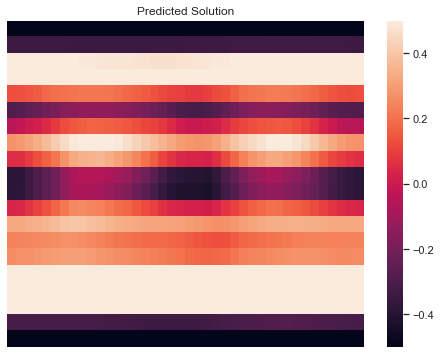

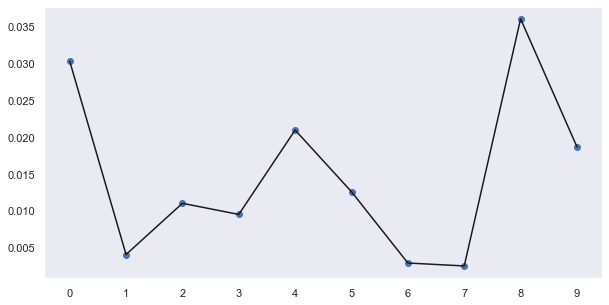

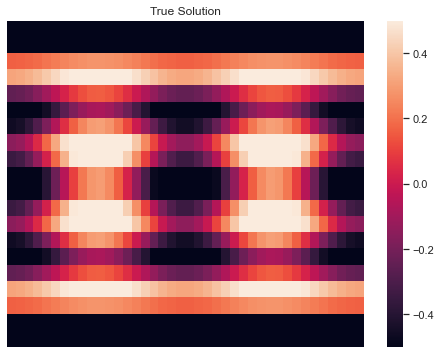

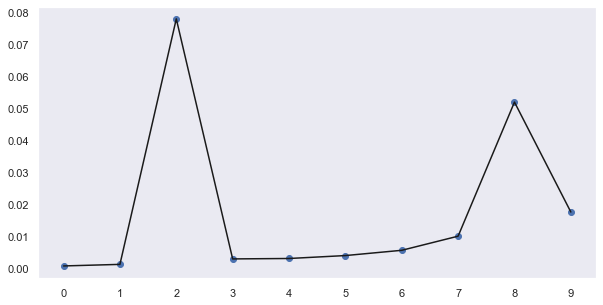

In [5]:
max_iter = 2000
model.train()

iteration 0: loss = 0.9372851252555847, pde loss = 0.9353917837142944


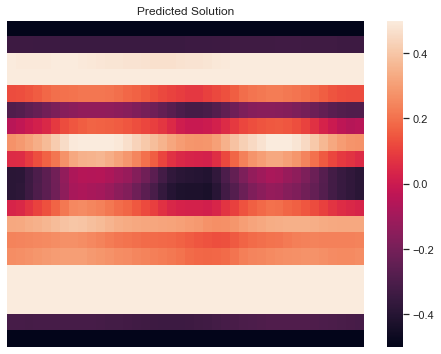

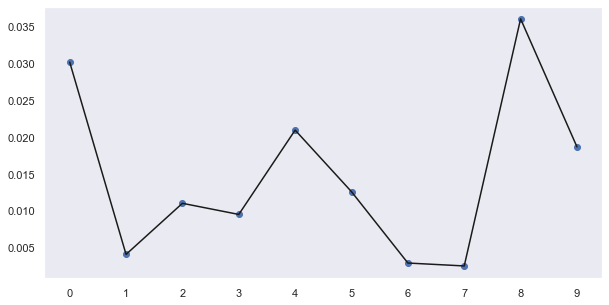

iteration 60: loss = 0.7464108467102051, pde loss = 0.7459346652030945
iteration 120: loss = 0.6101635098457336, pde loss = 0.6100530624389648
iteration 180: loss = 0.5133406519889832, pde loss = 0.513289749622345
iteration 240: loss = 0.44398969411849976, pde loss = 0.4439544379711151
iteration 300: loss = 0.3893679678440094, pde loss = 0.3893609642982483
iteration 360: loss = 0.34269046783447266, pde loss = 0.34269046783447266
iteration 420: loss = 0.30444756150245667, pde loss = 0.3044363260269165
iteration 480: loss = 0.26640820503234863, pde loss = 0.266388863325119
iteration 540: loss = 0.23804713785648346, pde loss = 0.23801955580711365
iteration 600: loss = 0.20889067649841309, pde loss = 0.2088593691587448
iteration 660: loss = 0.18540164828300476, pde loss = 0.18537651002407074
iteration 720: loss = 0.16788332164287567, pde loss = 0.16786186397075653
iteration 780: loss = 0.14826570451259613, pde loss = 0.14825202524662018
iteration 840: loss = 0.1337338536977768, pde loss = 

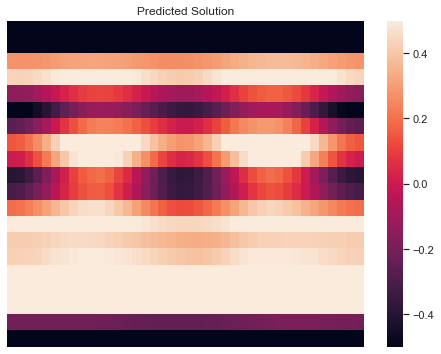

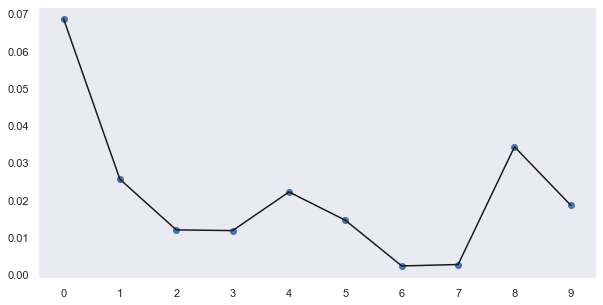

iteration 1260: loss = 0.07325190305709839, pde loss = 0.07325129956007004
iteration 1320: loss = 0.06853768229484558, pde loss = 0.06853737682104111
iteration 1380: loss = 0.06361107528209686, pde loss = 0.06361032277345657
iteration 1440: loss = 0.05950300395488739, pde loss = 0.05950145795941353
iteration 1500: loss = 0.05627051368355751, pde loss = 0.056269388645887375
iteration 1560: loss = 0.05203329399228096, pde loss = 0.05203268676996231
iteration 1620: loss = 0.04888458177447319, pde loss = 0.04888376593589783
iteration 1680: loss = 0.04657150059938431, pde loss = 0.046570561826229095
iteration 1740: loss = 0.04566365107893944, pde loss = 0.045662689954042435
iteration 1800: loss = 0.04199311137199402, pde loss = 0.04199310764670372
iteration 1860: loss = 0.04000120982527733, pde loss = 0.04000120237469673
iteration 1920: loss = 0.036578040570020676, pde loss = 0.03657757118344307
iteration 1980: loss = 0.0420546755194664, pde loss = 0.042054433375597
iteration 2040: loss = 0

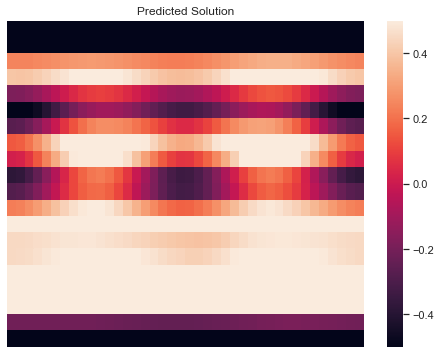

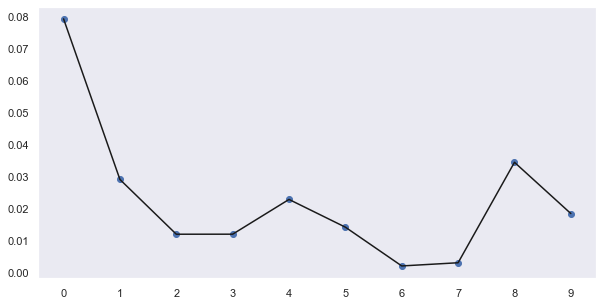

iteration 2460: loss = 0.04509114474058151, pde loss = 0.04508845880627632
iteration 2520: loss = 0.04842659831047058, pde loss = 0.0484255775809288
iteration 2580: loss = 0.023964522406458855, pde loss = 0.023963695392012596
iteration 2640: loss = 0.027087261900305748, pde loss = 0.027086948975920677
iteration 2700: loss = 0.04794483259320259, pde loss = 0.0479433536529541
iteration 2760: loss = 0.06649144738912582, pde loss = 0.0664907917380333
iteration 2820: loss = 0.04236539080739021, pde loss = 0.042364753782749176
iteration 2880: loss = 0.049057524651288986, pde loss = 0.049053605645895004
iteration 2940: loss = 0.031056612730026245, pde loss = 0.0310549046844244
iteration 3000: loss = 0.018061254173517227, pde loss = 0.01806115359067917
iteration 3060: loss = 0.01808577962219715, pde loss = 0.018085086718201637
iteration 3120: loss = 0.01829242892563343, pde loss = 0.018291838467121124
iteration 3180: loss = 0.03587229549884796, pde loss = 0.0358712263405323
iteration 3240: los

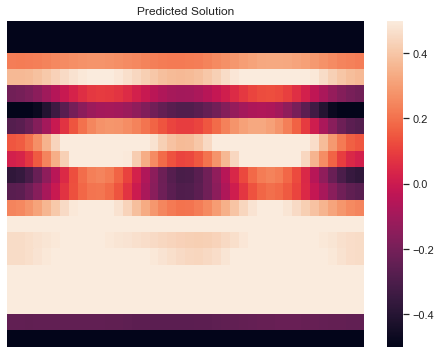

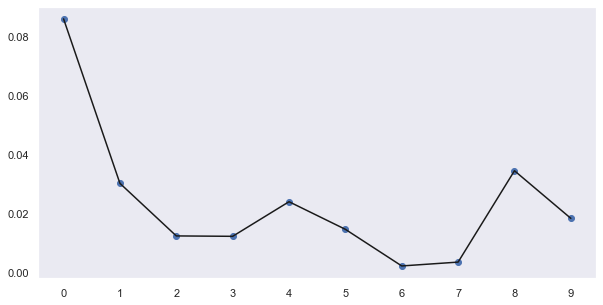

iteration 3660: loss = 0.026206662878394127, pde loss = 0.02620614692568779
iteration 3720: loss = 0.013595922850072384, pde loss = 0.013595590367913246
iteration 3780: loss = 0.017161937430500984, pde loss = 0.017161324620246887
iteration 3840: loss = 0.013921324163675308, pde loss = 0.013921038247644901
iteration 3900: loss = 0.04411107301712036, pde loss = 0.044109366834163666
iteration 3960: loss = 0.042102936655282974, pde loss = 0.04210013896226883
iteration 4020: loss = 0.015474597923457623, pde loss = 0.01547438744455576
iteration 4080: loss = 0.027017956599593163, pde loss = 0.027016792446374893
iteration 4140: loss = 0.020793704316020012, pde loss = 0.020793579518795013
iteration 4200: loss = 0.2034120410680771, pde loss = 0.20338645577430725
iteration 4260: loss = 0.009321127086877823, pde loss = 0.009321114048361778
iteration 4320: loss = 0.009223978966474533, pde loss = 0.009223933331668377
iteration 4380: loss = 0.009899276308715343, pde loss = 0.009898747317492962
iterat

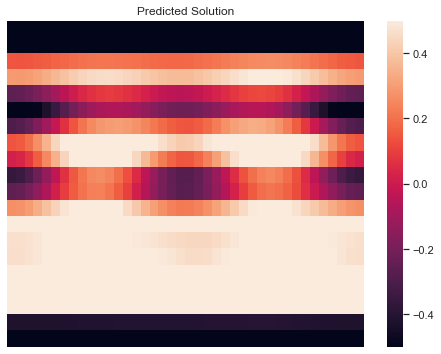

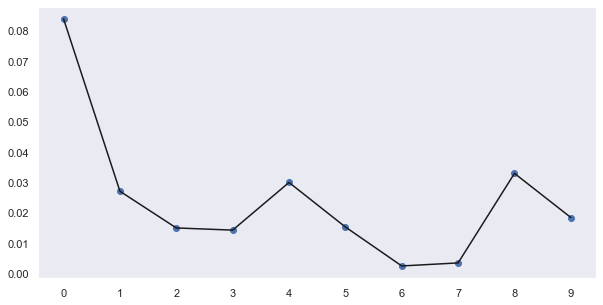

iteration 4860: loss = 0.04981677606701851, pde loss = 0.04981527850031853
iteration 4920: loss = 0.007205190137028694, pde loss = 0.007205002475529909
iteration 4980: loss = 0.006676113232970238, pde loss = 0.00667608855292201
iteration 5040: loss = 0.01053149625658989, pde loss = 0.010531178675591946
iteration 5100: loss = 0.006489557679742575, pde loss = 0.006489553488790989
iteration 5160: loss = 0.02386593259871006, pde loss = 0.023861201480031013
iteration 5220: loss = 0.0765887051820755, pde loss = 0.07655633240938187
iteration 5280: loss = 0.006099259946495295, pde loss = 0.006099245510995388
iteration 5340: loss = 0.009620138444006443, pde loss = 0.009616170078516006
iteration 5400: loss = 0.0065738181583583355, pde loss = 0.006573815830051899
iteration 5460: loss = 0.006020595319569111, pde loss = 0.0060204011388123035
iteration 5520: loss = 0.01267277356237173, pde loss = 0.012670236639678478
iteration 5580: loss = 0.00807157438248396, pde loss = 0.008069565519690514
iterati

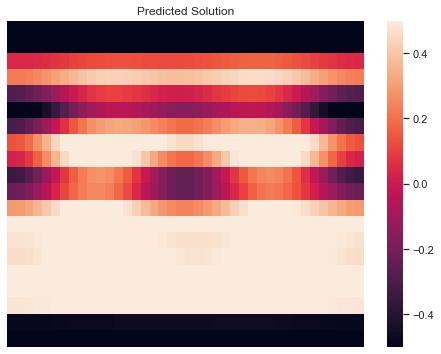

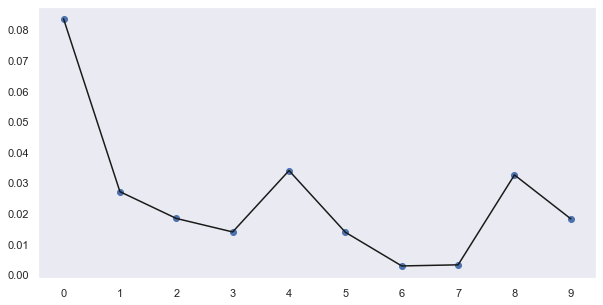

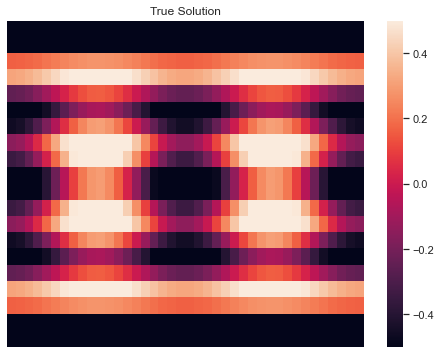

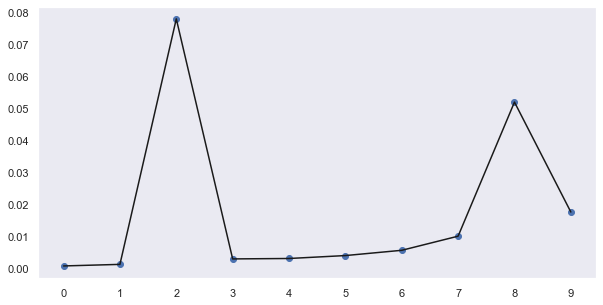

In [6]:
model.train()